# Notebook to make plots from saved files

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from jax import config
import mrcfile

from simplecryoem.utils import mip_z
from simplecryoem.fsc import calc_fsc, average_shells, average_shells_2D

2024-10-14 03:24:10.205376: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6
config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# We're working with this data:
# data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
# star_file = "particles_crossvalidation_train_1.star"

N0 = 105519
N = 50000
nx0 = 320
nx = 192
nx_crop = 192
pixel_size = 1.31
x_grid = [2.38549618e-03, 1.92000000e02]
interp_method = "tri"

In [4]:
savefig = False

In [5]:
out_dir =  "../../../simplecryoem_output/empiar_10076/"

In [6]:
mask = jnp.load(f'{out_dir}/mask.npy')
mask2d = mask[0].reshape(-1)

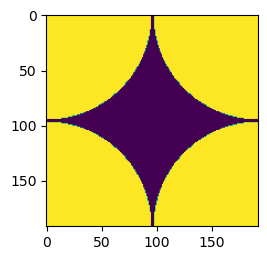

In [7]:
plt.rcParams["figure.figsize"] = 6, 6

plt.subplot(1, 2, 1)
plt.imshow(mask[0])

plt.rcParams["figure.figsize"] = 6, 6

### Preconditioner

In [8]:
interp_method = "tri"
# n_epochs = 2
n_epochs = 100 #400

precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"
D0 = jnp.load(precon_filename)

In [9]:
precon_filename

'../../../simplecryoem_output/empiar_10076//D0_tri_nx192_N50000_100epochs.npy'

In [10]:
savefig = False 

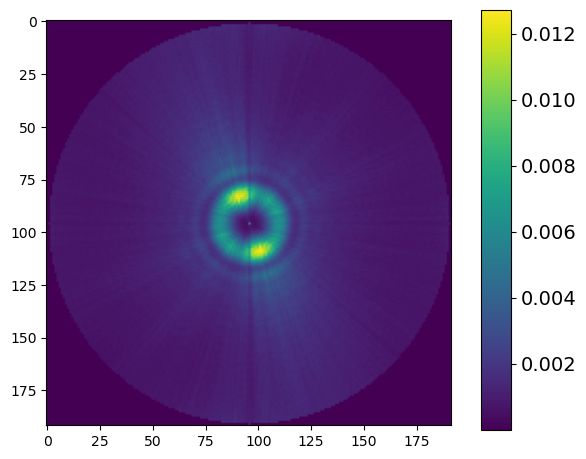

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(jnp.fft.fftshift(jnp.abs(D0[0])))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig(f"preconditioner_{interp_method}.eps")
    plt.savefig(f"preconditioner_{interp_method}_tight.eps", bbox_inches="tight")

### Load iterates

In [12]:
iterates_file_root = f"{out_dir}/iterates_{interp_method}/"

In [14]:
iterates_np = jnp.load(f"{iterates_file_root}/iterates_np.npy")
loss_np = jnp.load(f"{iterates_file_root}/iterates_np_loss.npy")
step_sizes_np = jnp.load(f"{iterates_file_root}/step_sizes_np.npy")

In [25]:
iterates_pp = jnp.load(f"{iterates_file_root}/iterates_pp.npy")
loss_pp = jnp.load(f"{iterates_file_root}/iterates_pp_loss.npy")
step_sizes_pp = jnp.load(f"{iterates_file_root}/step_sizes_pp.npy")

In [17]:
iterates_ep = jnp.load(f"{iterates_file_root}/iterates_ep.npy")
loss_ep = jnp.load(f"{iterates_file_root}/iterates_ep_loss.npy")
step_sizes_ep = jnp.load(f"{iterates_file_root}/step_sizes_ep.npy")

In [20]:
iterates_ep_nothresh = jnp.load(f"{iterates_file_root}/iterates_ep_nothresh.npy")
loss_ep_nothresh = jnp.load(f"{iterates_file_root}/iterates_ep_nothresh_loss.npy")
step_sizes_ep_nothresh = jnp.load(f"{iterates_file_root}/step_sizes_ep_nothresh.npy")

### Load the L-BFGS volume

In [21]:
# Load
# nnstring = "nn_"
nnstring = ""
N_iters = 750

with mrcfile.open(f"{out_dir}//v_rec_lbfgs_{nnstring}{N_iters}_nx.mrc") as mrc:
    vr_lbfgs = mrc.data

v_lbfgs = jnp.fft.fftn(jnp.fft.fftshift((vr_lbfgs)))

In [22]:
# For the L-BFGS loss, copying the value from the 1_Preconditioned_SGD.ipynb notebook instead of computing it
loss_lbfgs = 1563494762.5268562

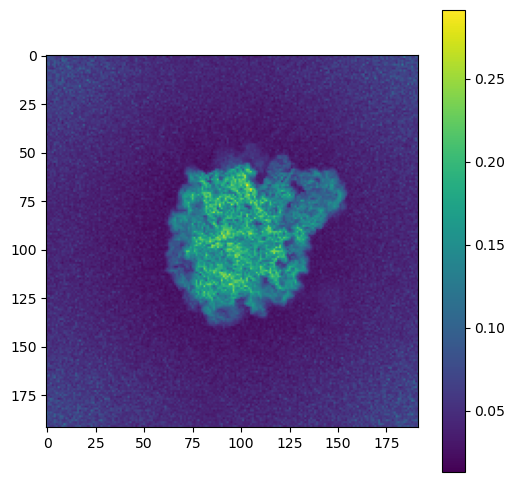

In [23]:
mip_z(vr_lbfgs)
plt.colorbar()

### Make plots

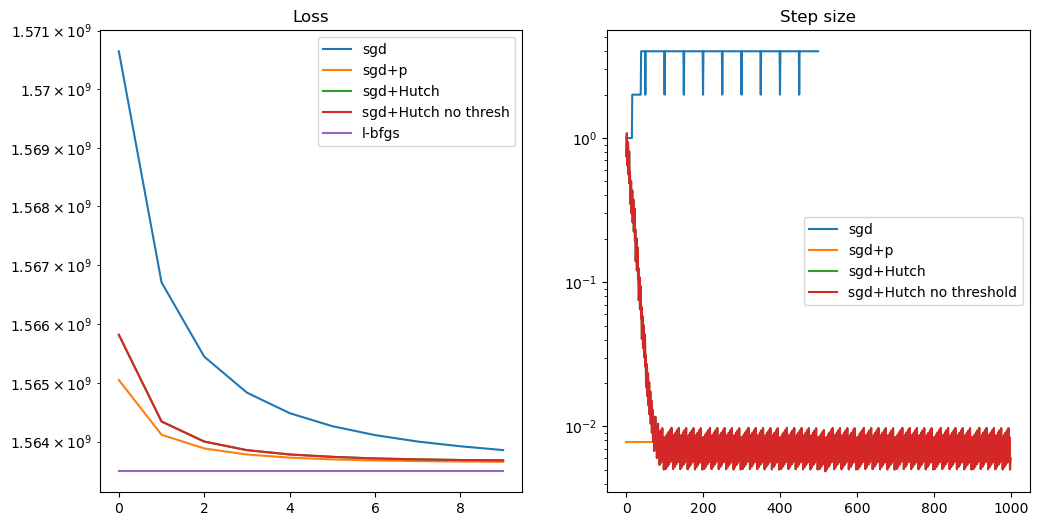

In [28]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(121)
plt.semilogy(loss_np)
plt.semilogy(loss_pp)
plt.semilogy(loss_ep)
plt.semilogy(loss_ep_nothresh)
plt.semilogy(loss_lbfgs * jnp.ones(loss_np.shape))
plt.legend(["sgd", "sgd+p", "sgd+Hutch", "sgd+Hutch no thresh", "l-bfgs"])
plt.title("Loss")

plt.subplot(122)
plt.semilogy(step_sizes_np)
plt.semilogy(step_sizes_pp)
plt.semilogy(step_sizes_ep)
plt.semilogy(step_sizes_ep_nothresh)
plt.legend(["sgd", "sgd+p", "sgd+Hutch", "sgd+Hutch no threshold"])
plt.title("Step size")

plt.rcParams["figure.figsize"] = 6, 6

### Errors and FSCs

In [29]:
def err_px(v1, v2):
    err = 1 / 2 * jnp.real(jnp.conj(v1 - v2) * (v1 - v2))
    res, avg_err, n_pts, max_err, median_err = average_shells(err, x_grid)

    return jnp.array([avg_err, max_err, median_err])


err_px_iterates = jax.vmap(lambda vv: err_px(v_lbfgs, vv), in_axes=0, out_axes=1)
fsc_iterates = jax.vmap(
    lambda vv: calc_fsc(v_lbfgs, vv, [1, nx_crop]), in_axes=0, out_axes=1
)

In [31]:
averr_np, maxerr_np, mederr_np = err_px_iterates(jnp.array(iterates_np))
averr_pp, maxerr_pp, mederr_pp = err_px_iterates(jnp.array(iterates_pp))
averr_ep, maxerr_ep, mederr_ep = err_px_iterates(jnp.array(iterates_ep))
averr_ep_nothresh, maxerr_ep_nothresh, mederr_ep_nothresh = err_px_iterates(jnp.array(iterates_ep_nothresh))

print(averr_np.shape)
print(maxerr_np.shape)
print(mederr_np.shape)

(11, 55)
(11, 55)
(11, 55)


In [32]:
res, fsc_np, shell_pts = fsc_iterates(jnp.array(iterates_np))
res, fsc_pp, shell_pts = fsc_iterates(jnp.array(iterates_pp))
res, fsc_ep, shell_pts = fsc_iterates(jnp.array(iterates_ep))
res, fsc_ep_nothresh, shell_pts = fsc_iterates(jnp.array(iterates_ep_nothresh))

print(fsc_np.shape)
print(fsc_pp.shape)
print(fsc_ep.shape)

(11, 55)
(11, 55)
(11, 55)


In [33]:
# Lower thershold for the preconditioner
# We take this to be the 1/(N points in the largest Fourier shell)
_, _, shell_pts = calc_fsc(D0, D0, [1, D0.shape[0]])
alpha = 1 / jnp.max(shell_pts)
print(alpha)
D0hat = jnp.maximum(jnp.abs(D0), alpha)

_, precon_radial_mean, _, precon_radial_max, precon_radial_median = average_shells(
    (1 / jnp.abs(D0)), x_grid
)
_, D0_radial_mean, _, D0_radial_max, D0_radial_median = average_shells(
    jnp.abs(D0), x_grid
)

(
    _,
    precon_hat_radial_mean,
    _,
    precon_hat_radial_max,
    precon_hat_radial_median,
) = average_shells((1 / D0hat), x_grid)
_, D0hat_radial_mean, _, D0hat_radial_max, D0hat_radial_median = average_shells(
    D0hat, x_grid
)

5.213981813631434e-06


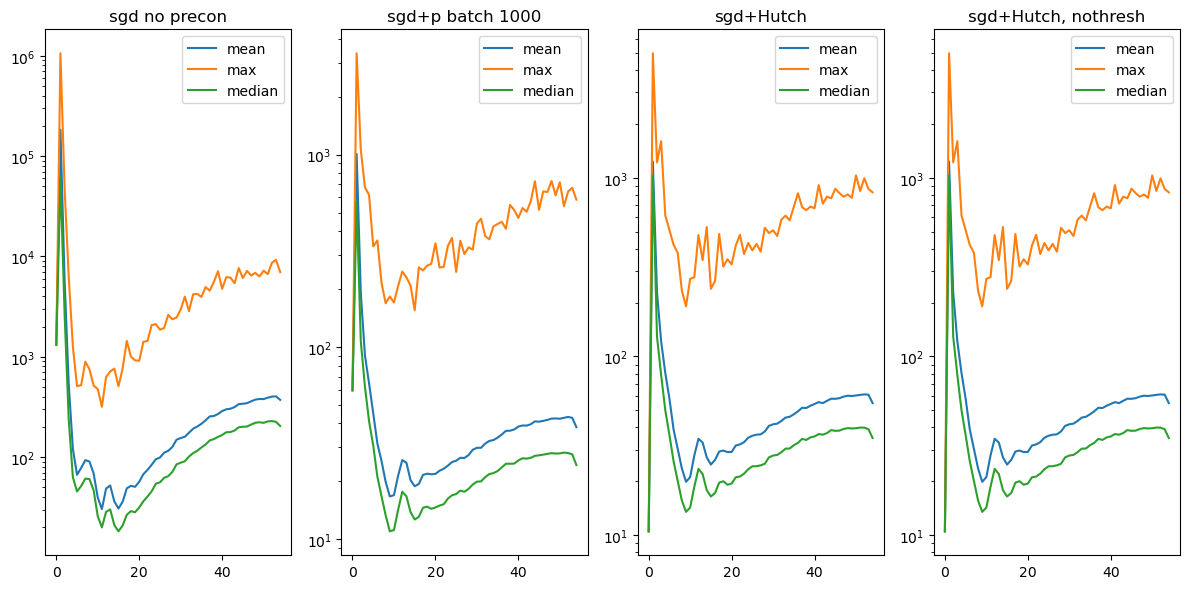

In [36]:
idx = 10

plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(141)
plt.semilogy((averr_np[idx]))
plt.semilogy((maxerr_np[idx]))
plt.semilogy((mederr_np[idx]))
plt.legend(["mean", "max", "median"])
plt.title("sgd no precon")
plt.tight_layout()

plt.subplot(142)
plt.semilogy((averr_pp[idx]))
plt.semilogy((maxerr_pp[idx]))
plt.semilogy((mederr_pp[idx]))
plt.legend(["mean", "max", "median"])
plt.title("sgd+p batch 1000")

plt.subplot(143)
plt.semilogy((averr_ep[idx]))
plt.semilogy((maxerr_ep[idx]))
plt.semilogy((mederr_ep[idx]))
plt.legend(["mean", "max", "median"])
plt.title("sgd+Hutch")
plt.tight_layout()

plt.subplot(144)
plt.semilogy((averr_ep_nothresh[idx]))
plt.semilogy((maxerr_ep_nothresh[idx]))
plt.semilogy((mederr_ep_nothresh[idx]))
plt.legend(["mean", "max", "median"])
plt.title("sgd+Hutch, nothresh")
plt.tight_layout()


plt.rcParams["figure.figsize"] = 6, 6

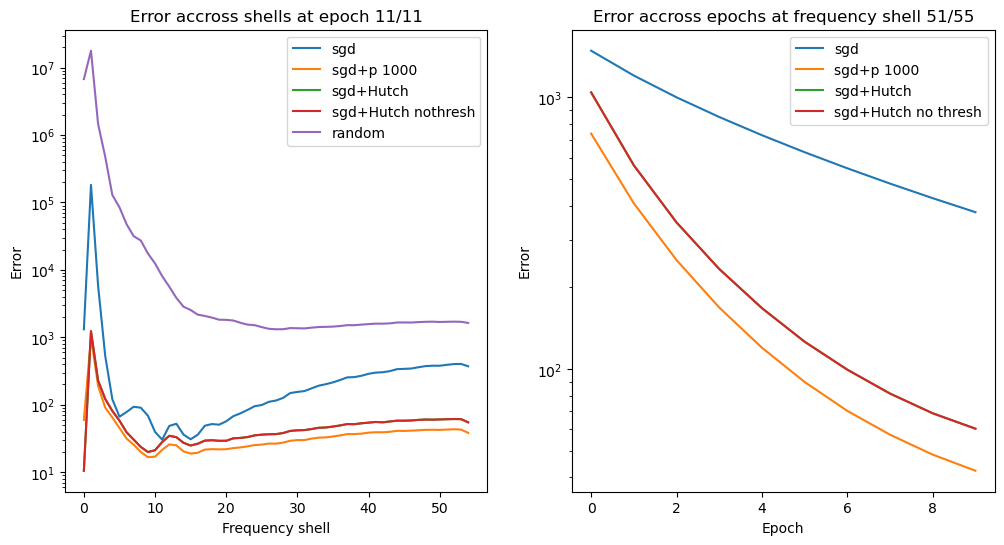

In [41]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(121)

idx = 10
plt.semilogy(averr_np[idx])
plt.semilogy(averr_pp[idx])
plt.semilogy(averr_ep[idx])
plt.semilogy(averr_ep_nothresh[idx])
plt.semilogy(averr_ep[0])

plt.legend(["sgd", "sgd+p 1000", "sgd+Hutch", "sgd+Hutch nothresh", "random"])
plt.xlabel("Frequency shell")
plt.ylabel("Error")
plt.title(f"Error accross shells at epoch {idx+1}/{fsc_np.shape[0]}")

plt.subplot(122)

idx_shell = 50
plt.semilogy(averr_np[1:, idx_shell])
plt.semilogy(averr_pp[1:, idx_shell])
plt.semilogy(averr_ep[1:, idx_shell])
plt.semilogy(averr_ep_nothresh[1:, idx_shell])

plt.legend(["sgd", "sgd+p 1000", "sgd+Hutch", "sgd+Hutch no thresh"])
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title(f"Error accross epochs at frequency shell {idx_shell+1}/{fsc_np.shape[1]}")

plt.rcParams["figure.figsize"] = 6, 6

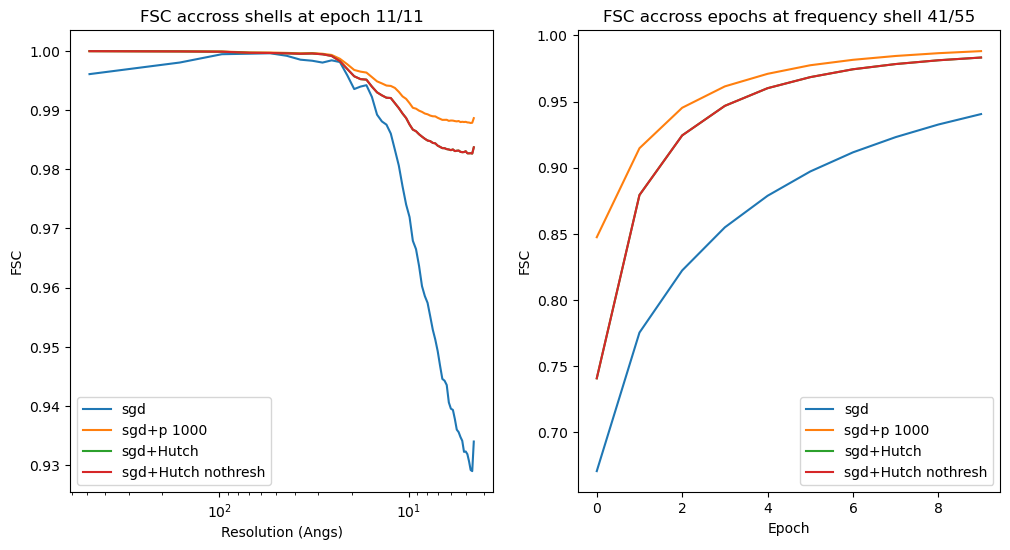

In [43]:
res_angs = nx0 * pixel_size / res[0]

plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(121)

idx = 10
plt.semilogx(res_angs[1:], fsc_np[idx, 1:])
plt.semilogx(res_angs[1:], fsc_pp[idx, 1:])
plt.semilogx(res_angs[1:], fsc_ep[idx, 1:])
plt.semilogx(res_angs[1:], fsc_ep_nothresh[idx, 1:])

plt.gca().invert_xaxis()
plt.legend(["sgd", "sgd+p 1000", "sgd+Hutch", "sgd+Hutch nothresh"])
plt.xlabel("Resolution (Angs)")
plt.ylabel("FSC")
plt.title(f"FSC accross shells at epoch {idx+1}/{fsc_np.shape[0]}")

plt.subplot(122)

idx_shell = 40
plt.plot(fsc_np[1:, idx_shell])
plt.plot(fsc_pp[1:, idx_shell])
plt.plot(fsc_ep[1:, idx_shell])
plt.plot(fsc_ep_nothresh[1:, idx_shell])


plt.legend(["sgd", "sgd+p 1000", "sgd+Hutch", "sgd+Hutch nothresh"])
plt.xlabel("Epoch")
plt.ylabel("FSC")
plt.title(f"FSC accross epochs at frequency shell {idx_shell+1}/{fsc_np.shape[1]}")

plt.rcParams["figure.figsize"] = 6, 6

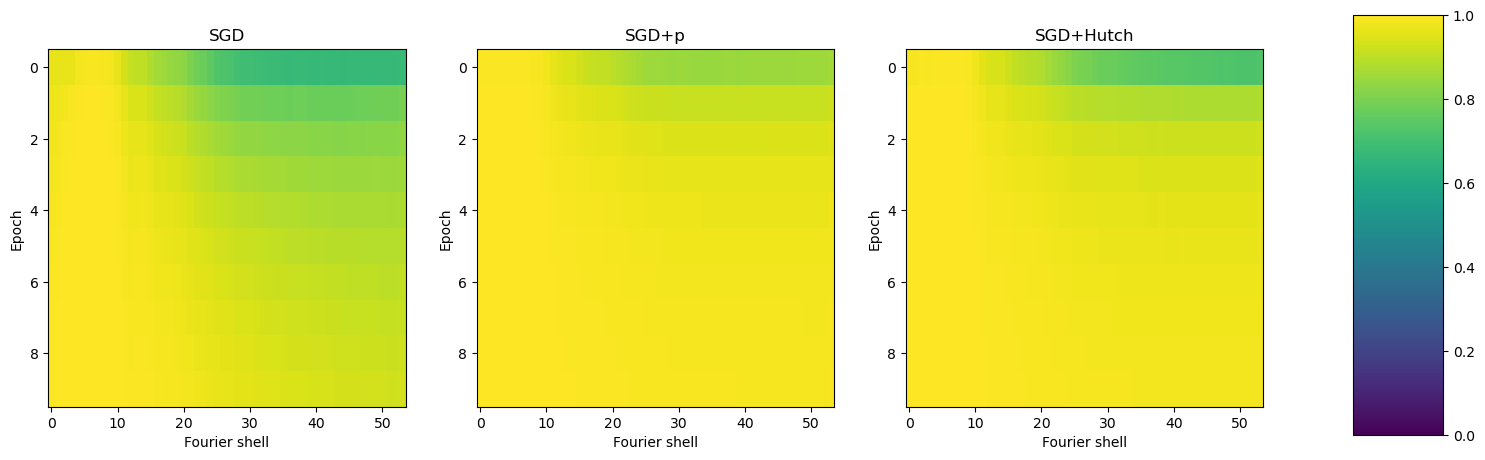

In [44]:
def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1] - extent[0]) / (extent[3] - extent[2])) / aspect)


plt.rcParams["figure.figsize"] = 18, 6

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(fsc_np[1:, 1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("SGD")

ax = fig.add_subplot(132)
ax.imshow(fsc_pp[1:, 1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("SGD+p")

ax = fig.add_subplot(133)
im = ax.imshow(fsc_ep[1:, 1:], vmin=0, vmax=1)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("SGD+Hutch")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [45]:
print(jnp.min(np.log(averr_np)))
print(jnp.min(np.log(averr_pp)))
print(jnp.min(np.log(averr_ep_nothresh)))

print(jnp.max(np.log(averr_np)))
print(jnp.max(np.log(averr_pp)))
print(jnp.max(np.log(averr_ep_nothresh)))

clim_min = jnp.min(
    jnp.array(
        [
            jnp.min(np.log(averr_np)),
            jnp.min(np.log(averr_pp)),
            jnp.min(np.log(averr_ep_nothresh)),
        ]
    )
)
clim_max = jnp.max(
    jnp.array(
        [
            jnp.max(np.log(averr_np)),
            jnp.max(np.log(averr_pp)),
            jnp.max(np.log(averr_ep_nothresh)),
        ]
    )
)

print(clim_min)
print(clim_max)

3.4115405220174555
2.703276615843807
2.350043740052471
16.696799186580538
16.696799186580538
16.696799186580538
2.350043740052471
16.696799186580538


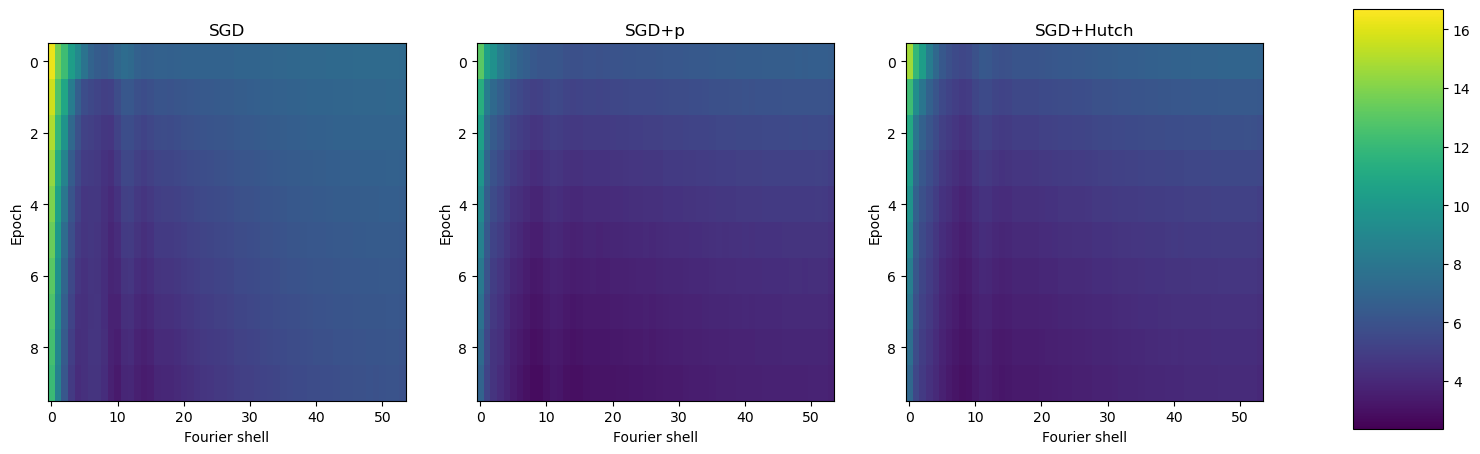

In [46]:
def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1] - extent[0]) / (extent[3] - extent[2])) / aspect)


plt.rcParams["figure.figsize"] = 18, 6

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(jnp.log(averr_np[1:, 1:]), vmin=clim_min, vmax=clim_max)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("SGD")

ax = fig.add_subplot(132)
ax.imshow(jnp.log(averr_pp[1:, 1:]), vmin=clim_min, vmax=clim_max)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("SGD+p")

ax = fig.add_subplot(133)
im = ax.imshow(jnp.log(averr_ep[1:, 1:]), vmin=clim_min, vmax=clim_max)
forceAspect(ax)
plt.xlabel("Fourier shell")
plt.ylabel("Epoch")
plt.title("SGD+Hutch")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.rcParams["figure.figsize"] = 6, 6

### And the preconditioner too

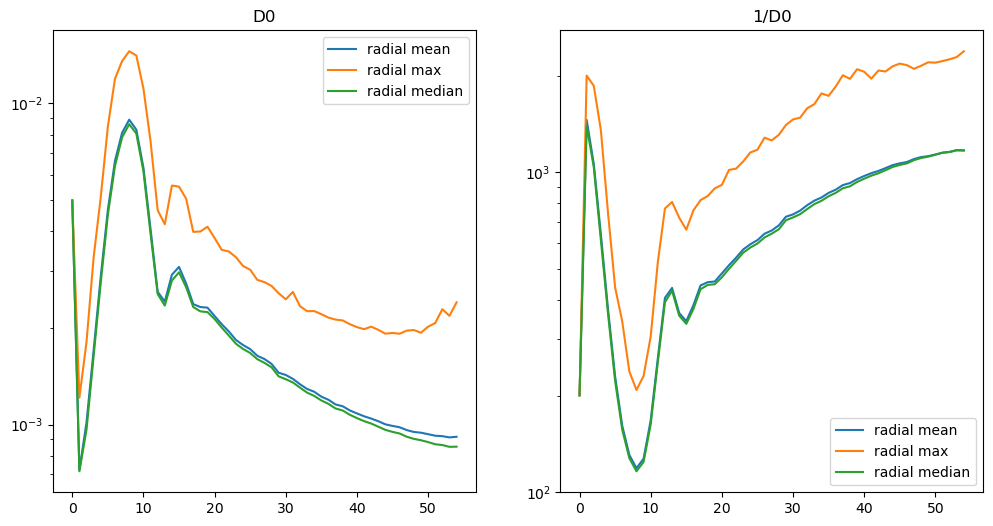

In [47]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(121)
plt.semilogy(D0_radial_mean)
plt.semilogy(D0_radial_max)
plt.semilogy(D0_radial_median)
plt.legend(["radial mean", "radial max", "radial median"])
plt.title("D0")

plt.subplot(122)
plt.semilogy(precon_radial_mean)
plt.semilogy(precon_radial_max)
plt.semilogy(precon_radial_median)
plt.legend(["radial mean", "radial max", "radial median"])
plt.title("1/D0")

plt.rcParams["figure.figsize"] = 6, 6

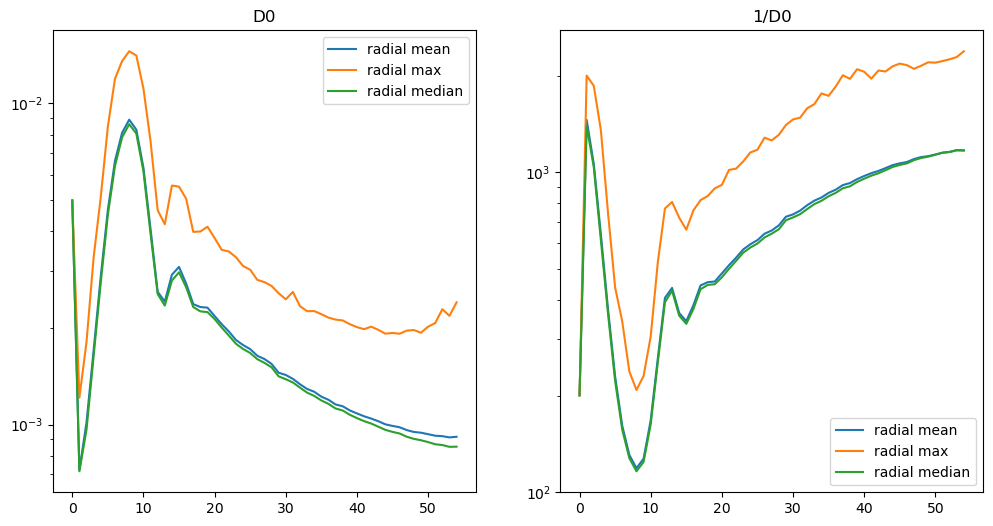

In [48]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(121)
plt.semilogy(D0hat_radial_mean)
plt.semilogy(D0hat_radial_max)
plt.semilogy(D0hat_radial_median)
plt.legend(["radial mean", "radial max", "radial median"])
plt.title("D0")

plt.subplot(122)
plt.semilogy(precon_hat_radial_mean)
plt.semilogy(precon_hat_radial_max)
plt.semilogy(precon_hat_radial_median)
plt.legend(["radial mean", "radial max", "radial median"])
plt.title("1/D0")

plt.rcParams["figure.figsize"] = 6, 6

### Gradient variance

In [51]:
saved_measures_dir = f'{out_dir}/saved_measures/'

In [52]:
grad_full = jnp.load(f"{saved_measures_dir}/grad_full.npy")
var_grad = jnp.load(f"{saved_measures_dir}/var_grad_1000.npy")

In [53]:
_, avgrad_full, _, _, _ = average_shells(jnp.abs(grad_full), x_grid)
_, av_var_grad, _, _, _ = average_shells(var_grad, x_grid)

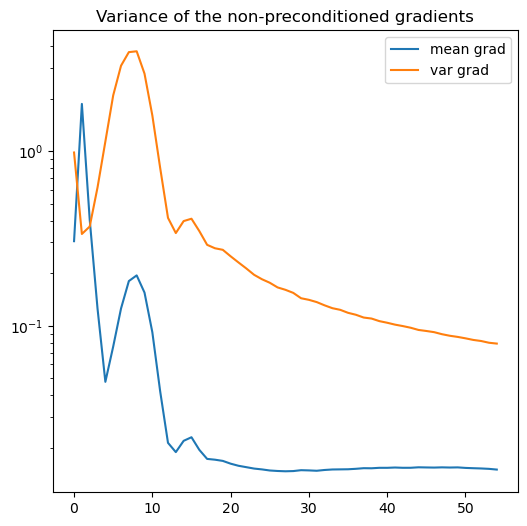

In [54]:
plt.semilogy(jnp.abs(avgrad_full))
plt.semilogy(jnp.abs(av_var_grad))

plt.title("Variance of the non-preconditioned gradients")
plt.legend(["mean grad", "var grad"])

In [55]:
grad_full_p_d0 = jnp.load(f"{saved_measures_dir}/grad_full_p_d0.npy")
var_grad_p_d0 = jnp.load(f"{saved_measures_dir}/var_grad_1000_p_d0.npy")

In [56]:
_, avgrad_full_p_d0, _, _, _ = average_shells(jnp.abs(grad_full_p_d0), x_grid)
_, av_var_grad_p_d0, _, _, _ = average_shells(var_grad_p_d0, x_grid)

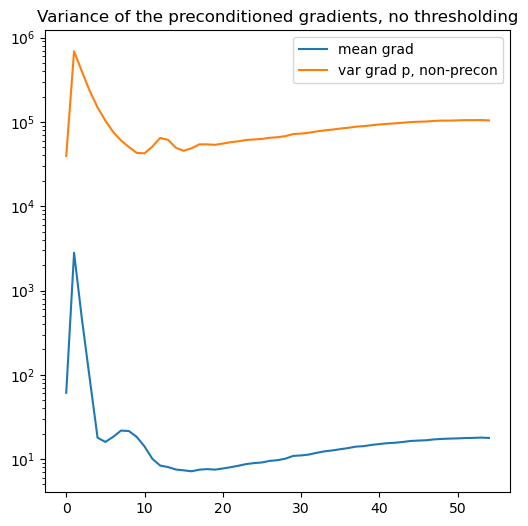

In [57]:
plt.semilogy(jnp.abs(avgrad_full_p_d0))
plt.semilogy(jnp.abs(av_var_grad_p_d0))

plt.title("Variance of the preconditioned gradients, no thresholding")
plt.legend(["mean grad", "var grad p, non-precon"])

In [58]:
grad_full_p_dhat = jnp.load(f"{saved_measures_dir}/grad_full_p_dhat.npy")
var_grad_p_dhat = jnp.load(f"{saved_measures_dir}/var_grad_1000_p_dhat.npy")

In [59]:
_, avgrad_full_p_dhat, _, _, _ = average_shells(jnp.abs(grad_full_p_dhat), x_grid)
_, av_var_grad_p_dhat, _, _, _ = average_shells(var_grad_p_dhat, x_grid)

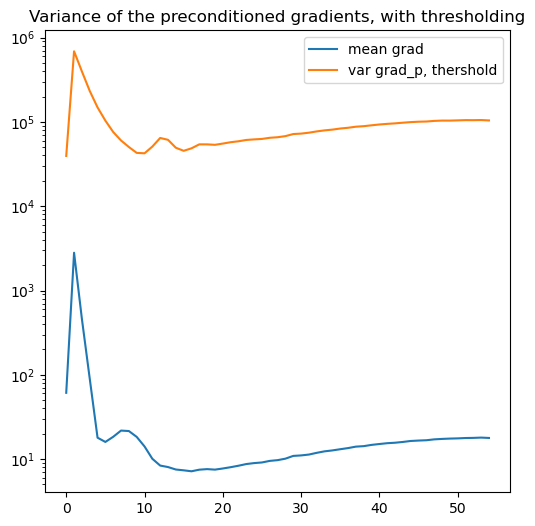

In [60]:
plt.semilogy(jnp.abs(avgrad_full_p_dhat))
plt.semilogy(jnp.abs(av_var_grad_p_dhat))

plt.title("Variance of the preconditioned gradients, with thresholding")
plt.legend(["mean grad", "var grad_p, thershold"])

#### The error and the variance of the _preconditioned_ gradient go up at the same time, so they are related => their common thing is the problem: the preconditioner

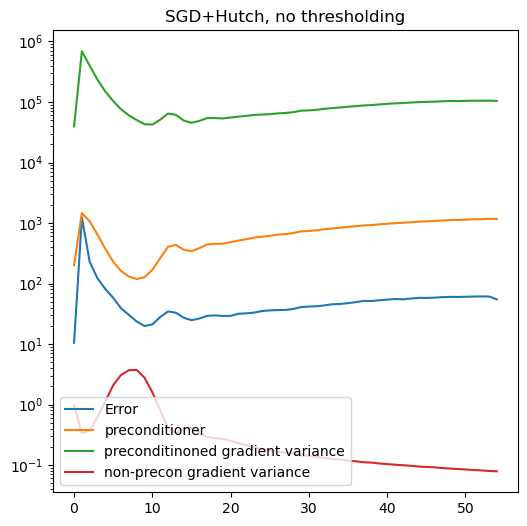

In [62]:
# Before thresholding:

plt.semilogy(averr_ep_nothresh[10])
plt.semilogy(precon_radial_mean)
plt.semilogy(jnp.abs(av_var_grad_p_d0))
plt.semilogy(av_var_grad)
plt.title("SGD+Hutch, no thresholding")
plt.legend(
    [
        "Error",
        "preconditioner",
        "preconditinoned gradient variance",
        "non-precon gradient variance",
    ]
)

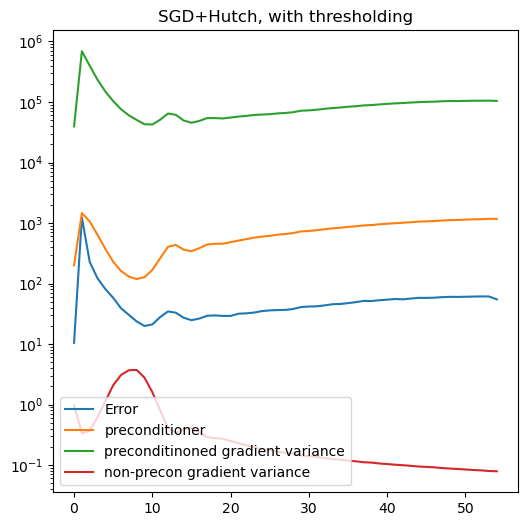

In [64]:
# After thresholding
plt.semilogy(averr_ep[10])
plt.semilogy(precon_hat_radial_mean)
plt.semilogy(jnp.abs(av_var_grad_p_dhat))
plt.semilogy(av_var_grad)
plt.title("SGD+Hutch, with thresholding")
plt.legend(
    [
        "Error",
        "preconditioner",
        "preconditinoned gradient variance",
        "non-precon gradient variance",
    ]
)

# Custom plots

### The nn preconditioner

In [65]:
savefig = False

In [66]:
interp_method = "nn"
n_epochs = 2
# n_epochs = 400

precon_filename = f"{out_dir}/D0_{interp_method}_nx{nx}_N{N}_{n_epochs}epochs.npy"
D0 = jnp.load(precon_filename)

plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0, :, :])))
# plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title("Diagonal of $H$", fontsize=22)
# plt.title("Diagonal of $H$ for $N=50000$", fontsize=22)


if savefig:
    plt.savefig(f"preconditioner_{interp_method}.eps", bbox_inches="tight")

FileNotFoundError: [Errno 2] No such file or directory: '../../../simplecryoem_output/empiar_10076//D0_nn_nx192_N50000_2epochs.npy'

### Before thresholding

In [67]:
savefig = False

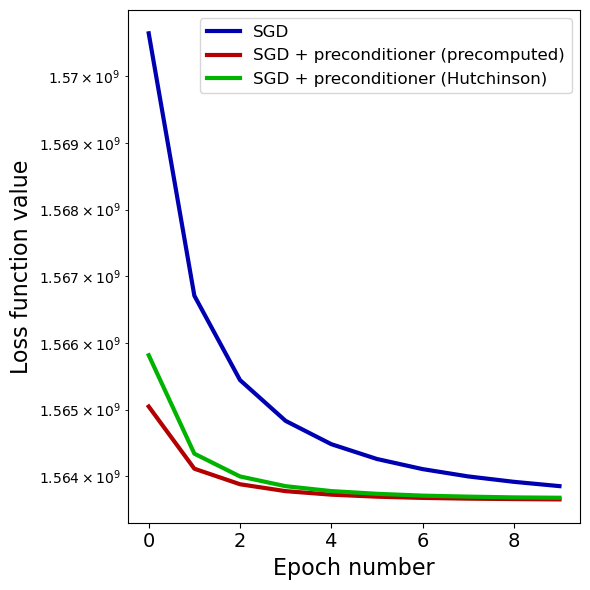

In [68]:
plt.plot
plt.semilogy(loss_np, linewidth=3, c=(0, 0, 0.7))
plt.semilogy(loss_pp, linewidth=3, c=(0.7, 0, 0))  # , linestyle='dotted')
# plt.semilogy(loss_o)
plt.semilogy(loss_ep, linewidth=3, c=(0, 0.7, 0))  # , linestyle='dashed')
# plt.semilogy(loss_lbfgs * jnp.ones(loss_rec.shape))
plt.legend(
    ["SGD", "SGD + preconditioner (precomputed)", "SGD + preconditioner (Hutchinson)"],
    fontsize=12,
)
# plt.title("Loss", fontsize=22)
plt.xlabel("Epoch number", fontsize=16)
plt.ylabel("Loss function value", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig("pre_thresh_epoch_loss.eps")  # , bbox_inches='tight')

In [49]:
savefig = False

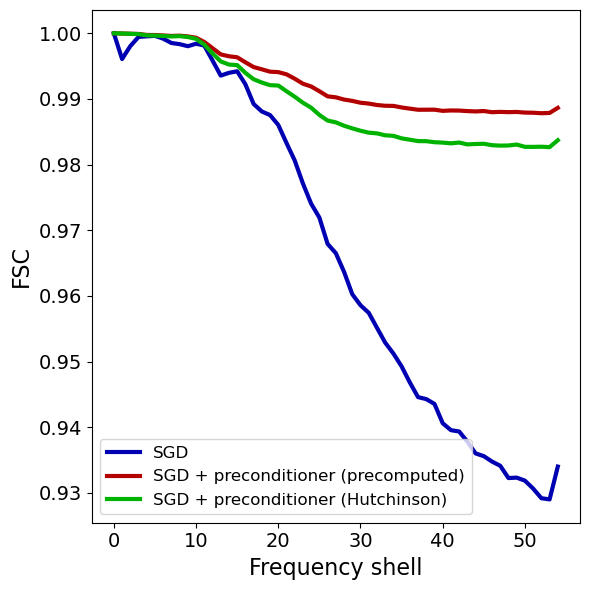

In [69]:
plt.plot((fsc_np[10]), linewidth=3, c=(0, 0, 0.7))
plt.plot((fsc_pp[10]), linewidth=3, c=(0.7, 0, 0))
plt.plot((fsc_ep_nothresh[10]), linewidth=3, c=(0, 0.7, 0))
plt.legend(
    ["SGD", "SGD + preconditioner (precomputed)", "SGD + preconditioner (Hutchinson)"],
    fontsize=12,
)
# plt.title("Fourier shell correlation (final epoch)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig("pre_thresh_shell_error.eps")  # , bbox_inches='tight')

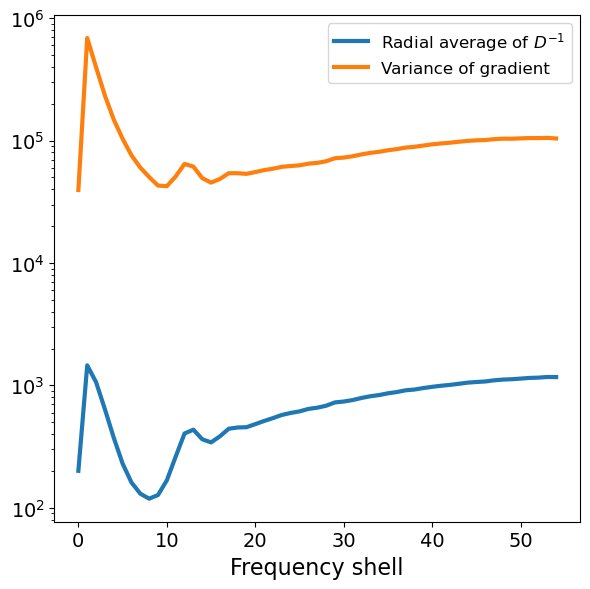

In [70]:
# ax1.semilogy(fsc_o_nothresh[10], linewidth=3, color='g')


plt.semilogy(precon_radial_mean, linewidth=3)
plt.semilogy(jnp.abs(av_var_grad_p_d0), linewidth=3)
plt.legend(["Radial average of $D^{-1}$", "Variance of gradient"], fontsize=12)
# plt.title("Grad variance and $D^{-1}$ (final epoch)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
# plt.ylabel("FSC", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig("pre_thresh_shell_error_variance.eps")  # , bbox_inches='tight')

### After thresholding

In [71]:
savefig = False 

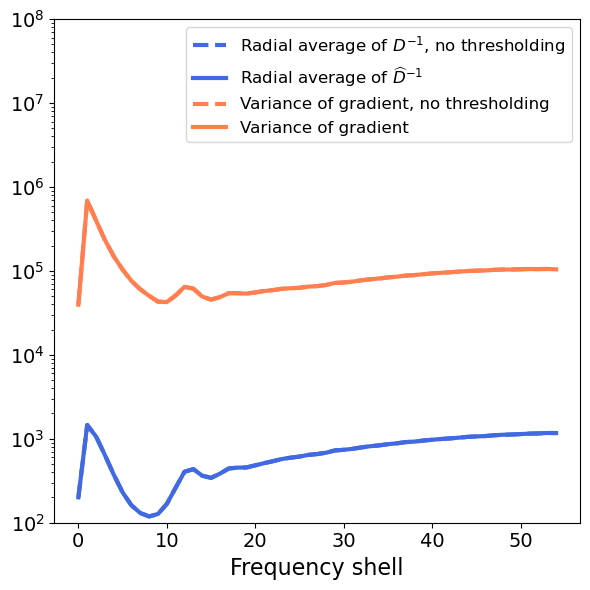

In [72]:
plt.semilogy(precon_radial_mean, linewidth=3, linestyle="dashed", color="royalblue")
plt.semilogy(precon_hat_radial_mean, linewidth=3, color="royalblue")

plt.semilogy(jnp.abs(av_var_grad_p_d0), linewidth=3, linestyle="dashed", color="coral")
plt.semilogy(jnp.abs(av_var_grad_p_dhat), linewidth=3, color="coral")

# plt.semilogy((fsc_o[10]), linewidth=3)
plt.legend(
    [
        "Radial average of $D^{-1}$, no thresholding",
        "Radial average of $\widehat{D}^{-1}$",
        "Variance of gradient, no thresholding",
        "Variance of gradient",
    ],
    fontsize=12,
    loc="best",
)

# Set upper axis limit to 10^8
plt.ylim([1e2, 1e8])


# plt.legend(["Variance of gradient"], fontsize=12)

# plt.title("Grad variance and $\hat{D}^{-1}$ (final epoch)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
# plt.ylabel("Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig("post_thresh_shell_error_variance.eps")

In [73]:
savefig = False

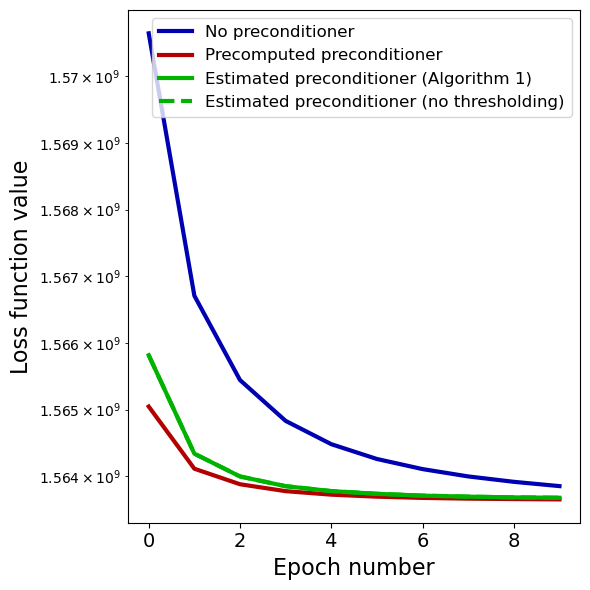

In [75]:
plt.plot
plt.semilogy(loss_np, linewidth=3, c=(0, 0, 0.7))
plt.semilogy(loss_pp, linewidth=3, c=(0.7, 0, 0))
# plt.semilogy(loss_o)
plt.semilogy(loss_ep, linewidth=3, c=(0, 0.7, 0))
plt.semilogy(loss_ep_nothresh, linewidth=3, c=(0, 0.7, 0), linestyle="dashed")

# plt.semilogy(loss_lbfgs * jnp.ones(loss_rec.shape))
plt.legend(
    [
        "No preconditioner",
        "Precomputed preconditioner",
        "Estimated preconditioner (Algorithm 1)",
        "Estimated preconditioner (no thresholding)",
    ],
    fontsize=12,
)
# plt.title("Loss", fontsize=22)
plt.xlabel("Epoch number", fontsize=16)
plt.ylabel("Loss function value", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig("post_thresh_epoch_loss.eps")  # , bbox_inches='tight')

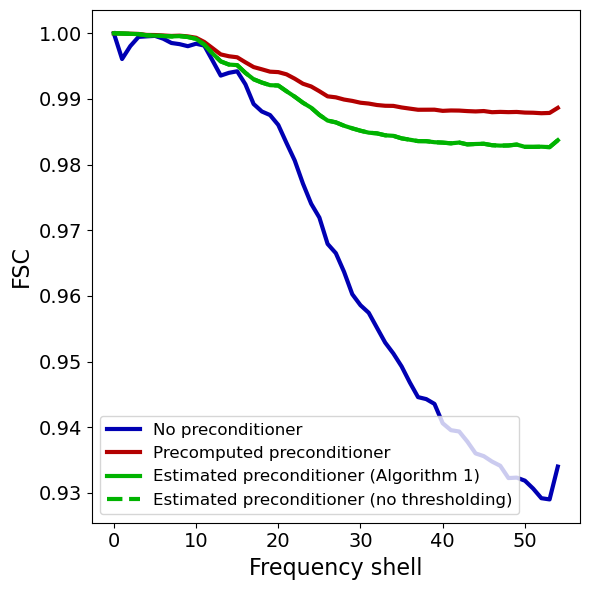

In [76]:
plt.plot((fsc_np[10]), linewidth=3, c=(0, 0, 0.7))
plt.plot((fsc_pp[10]), linewidth=3, c=(0.7, 0, 0))
plt.plot((fsc_ep[10]), linewidth=3, c=(0, 0.7, 0))
plt.plot((fsc_ep_nothresh[10]), linewidth=3, c=(0, 0.7, 0), linestyle="dashed")

plt.legend(
    [
        "No preconditioner",
        "Precomputed preconditioner",
        "Estimated preconditioner (Algorithm 1)",
        "Estimated preconditioner (no thresholding)",
    ],
    fontsize=12,
    loc="lower left",
)

# plt.title("Fourier shell correlation (final epoch)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig("post_thresh_shell_error.eps")  # , bbox_inches='tight')

In [77]:
savefig = False

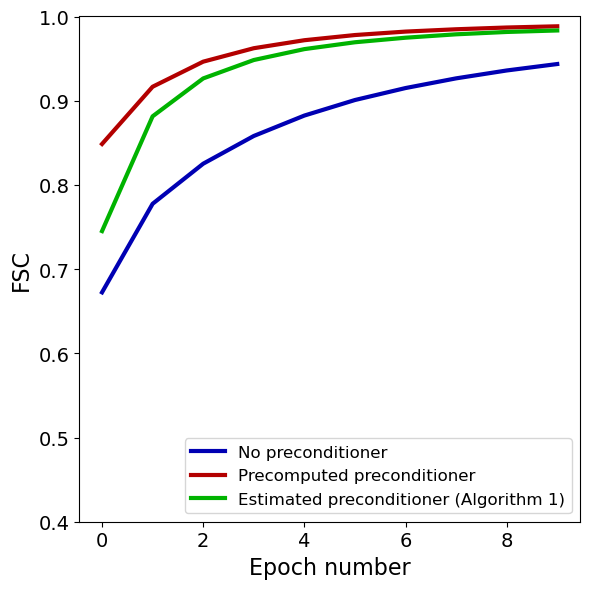

In [92]:
# Plot at idx_shell 9, 16, 39

N_shells = averr_np.shape[1]
idx_shell = 39

plt.plot(fsc_np[1:, idx_shell], linewidth=3, c=(0, 0, 0.7))
plt.plot(fsc_pp[1:, idx_shell], linewidth=3, c=(0.7, 0, 0))
plt.plot(fsc_ep[1:, idx_shell], linewidth=3, c=(0, 0.7, 0))
# plt.plot(fsc_o_nothresh[1:, idx_shell])
plt.ylim([0.4, 1])

# plt.title(f"FSC at Fourier shell {idx_shell+1}/{N_shells}", fontsize=22)
plt.legend(
    [
        "No preconditioner",
        "Precomputed preconditioner",
        "Estimated preconditioner (Algorithm 1)",
    ],
    fontsize=12,
    loc="lower right",
)

plt.xlabel("Epoch number", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig(f"post_thresh_epoch_error_shell{idx_shell+1}.eps")

### The heatmaps with the errors

In [95]:
print(averr_np.shape)
print(
    jnp.tile(jnp.max(averr_np, axis=0, keepdims=True), (averr_np.shape[0], 1)).shape
)

(11, 55)
(11, 55)


In [97]:
# To allow for a better comparison between methods across epochs,
# it's better to normalize each epoch

averr_np_norm = averr_np / np.tile(
    jnp.max(averr_np, axis=0, keepdims=True), (averr_np.shape[0], 1)
)
averr_pp_norm = averr_pp / np.tile(
    jnp.max(averr_pp, axis=0, keepdims=True), (averr_pp.shape[0], 1)
)
averr_ep_norm = averr_ep / np.tile(
    jnp.max(averr_ep, axis=0, keepdims=True), (averr_ep.shape[0], 1)
)

In [98]:
print(jnp.min(jnp.log(averr_np_norm)))
print(jnp.min(jnp.log(averr_pp_norm)))
print(jnp.min(jnp.log(averr_ep_norm)))

print(jnp.max(jnp.log(averr_np_norm)))
print(jnp.max(jnp.log(averr_pp_norm)))
print(jnp.max(jnp.log(averr_ep_norm)))

clim_min = jnp.min(
    jnp.array(
        [
            jnp.min(np.log(averr_np_norm)),
            jnp.min(np.log(averr_pp_norm)),
            jnp.min(np.log(averr_ep_norm)),
        ]
    )
)
clim_max = jnp.max(
    jnp.array(
        [
            jnp.max(np.log(averr_np_norm)),
            jnp.max(np.log(averr_pp_norm)),
            jnp.max(np.log(averr_ep_norm)),
        ]
    )
)

print(clim_min)
print(clim_max)

-11.848019246655626
-13.024924651328048
-13.378157527119383
0.0
0.0
0.0
-13.378157527119383
0.0


In [99]:
savefig = False 

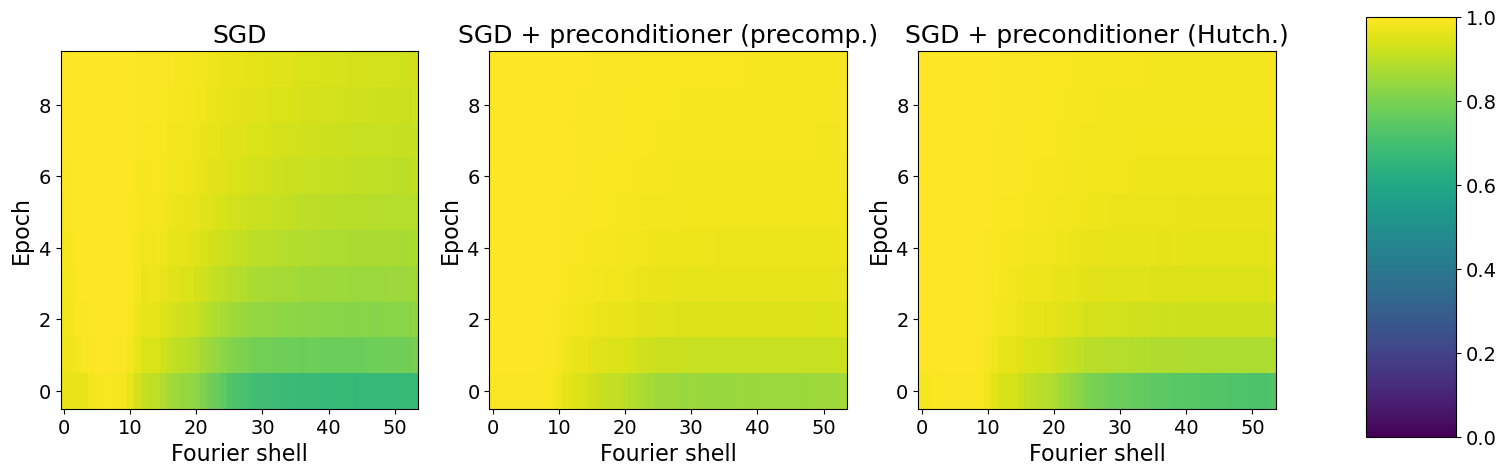

In [101]:
clim_min = 0
clim_max = 1


def forceAspect(ax, aspect=1):
    im = ax.get_images()
    extent = im[0].get_extent()
    ax.set_aspect(abs((extent[1] - extent[0]) / (extent[3] - extent[2])) / aspect)


plt.rcParams["figure.figsize"] = 18, 6

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(fsc_np[1:, 1:], vmin=clim_min, vmax=clim_max, origin="lower")
forceAspect(ax)
plt.xlabel("Fourier shell", fontsize=16)
plt.ylabel("Epoch", fontsize=16)
plt.title("SGD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax = fig.add_subplot(132)
ax.imshow(fsc_pp[1:, 1:], vmin=clim_min, vmax=clim_max, origin="lower")
forceAspect(ax)
plt.xlabel("Fourier shell", fontsize=16)
plt.ylabel("Epoch", fontsize=16)
plt.title("SGD + preconditioner (precomp.)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax = fig.add_subplot(133)
im = ax.imshow(fsc_ep[1:, 1:], vmin=clim_min, vmax=clim_max, origin="lower")
forceAspect(ax)
plt.xlabel("Fourier shell", fontsize=16)
plt.ylabel("Epoch", fontsize=16)
plt.title("SGD + preconditioner (Hutch.)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.rcParams["figure.figsize"] = 6, 6

if savefig:
    plt.savefig("post_thresh_heatmap_all.eps", bbox_inches="tight")

### And separate to save

In [102]:
savefig = False 

In [103]:
clim_min = 0
clim_max = 1

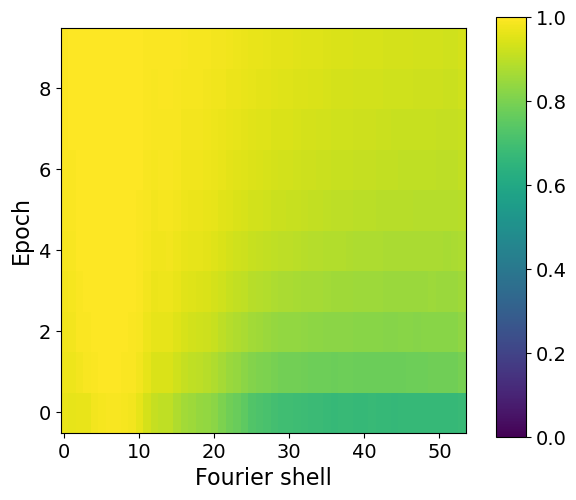

In [105]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow((fsc_np[1:, 1:]), vmin=clim_min, vmax=clim_max, origin="lower")
# ax.imshow(jnp.log(averr_rec_norm[1:,1:]), vmin=clim_min, vmax=clim_max)

forceAspect(ax)
plt.xlabel("Fourier shell", fontsize=16)
plt.ylabel("Epoch", fontsize=16)
# plt.title("SGD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig("post_thresh_heatmap_SGD.eps", bbox_inches="tight")

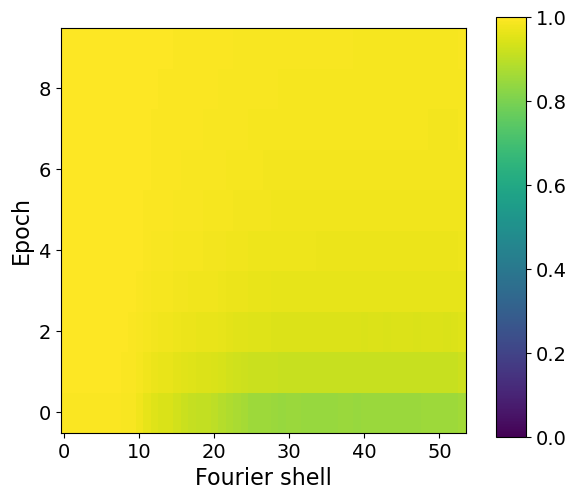

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.imshow(jnp.log(averr_rec_p_1000_norm[1:,1:]),  vmin=clim_min, vmax=clim_max, origin='lower')
im = ax.imshow((fsc_pp[1:, 1:]), vmin=clim_min, vmax=clim_max, origin="lower")
forceAspect(ax)
plt.xlabel("Fourier shell", fontsize=16)
plt.ylabel("Epoch", fontsize=16)
# plt.title("SGD + preconditioner (precomp.)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig("post_thresh_heatmap_SGD_p.eps", bbox_inches="tight")

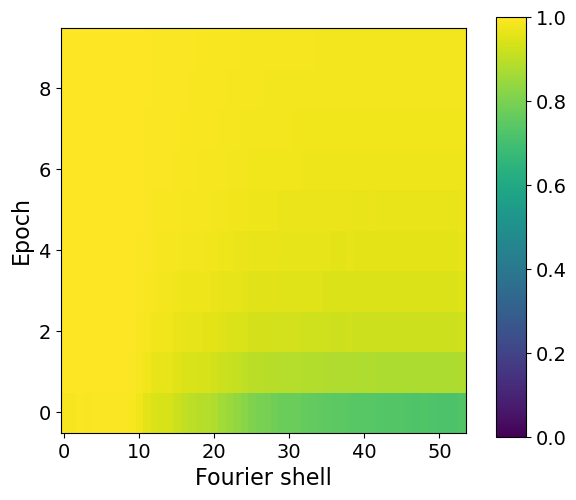

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)
# im = ax.imshow(jnp.log(averr_rec_o_norm[1:,1:]),  vmin=clim_min, vmax=clim_max, origin='lower')
im = ax.imshow((fsc_ep[1:, 1:]), vmin=clim_min, vmax=clim_max, origin="lower")

forceAspect(ax)
plt.xlabel("Fourier shell", fontsize=16)
plt.ylabel("Epoch", fontsize=16)
# plt.title("SGD + preconditioner (Hutch.)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if savefig:
    plt.savefig("post_thresh_heatmap_SGD_ep.eps", bbox_inches="tight")

## Same info as the heatmaps, but gradient color line plots

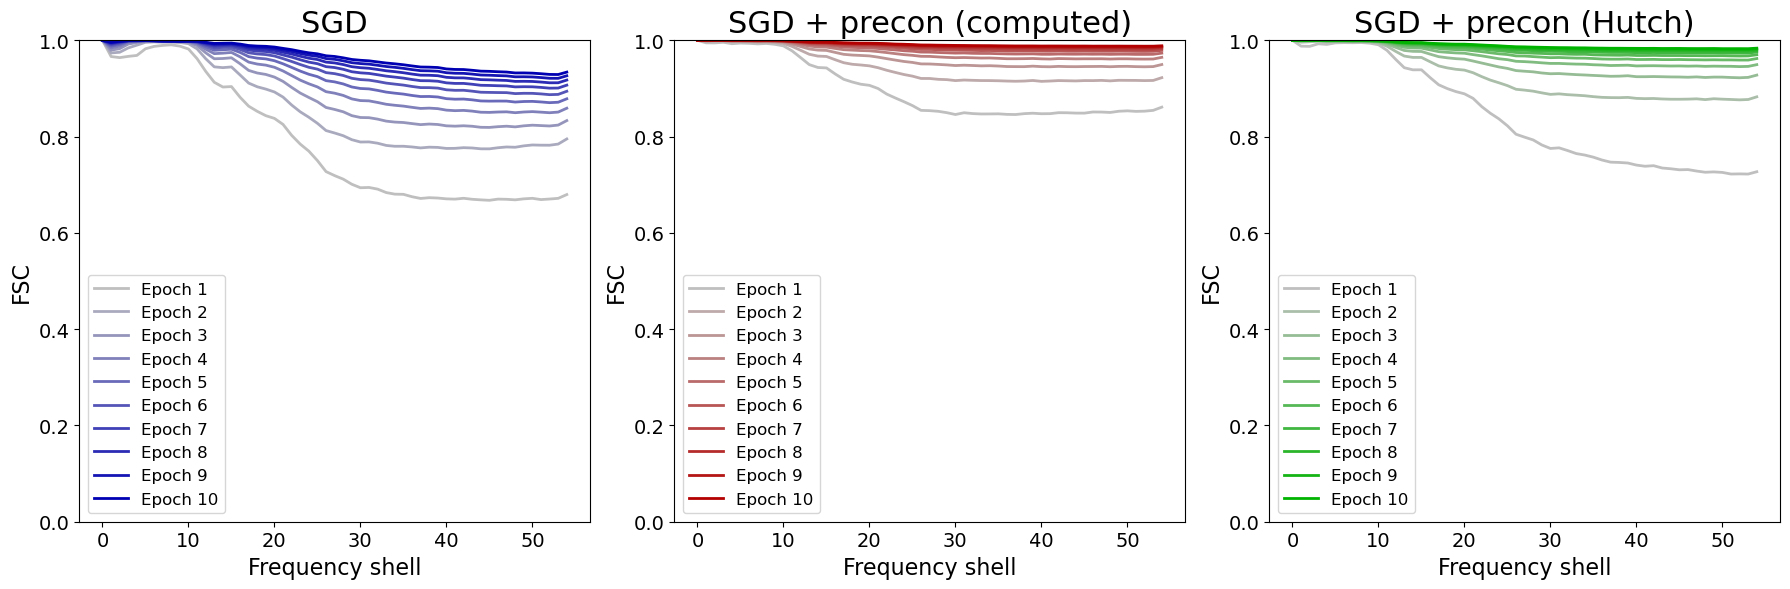

In [109]:
crange_color = np.linspace(0.75, 0.7, 10)
crange_other = np.linspace(0.75, 0.0, 10)

lgd = [
    "Epoch 1",
    "Epoch 2",
    "Epoch 3",
    "Epoch 4",
    "Epoch 5",
    "Epoch 6",
    "Epoch 7",
    "Epoch 8",
    "Epoch 9",
    "Epoch 10",
]

plt.rcParams["figure.figsize"] = 18, 6

plt.subplot(131)
for i in range(1, 11):
    c = (crange_other[i - 1], crange_other[i - 1], crange_color[i - 1])
    plt.plot(fsc_np[i, :], color=c, linewidth=2)
plt.ylim([0, 1])
plt.legend(lgd, fontsize=12)
plt.title("SGD", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.subplot(132)
for i in range(1, 11):
    c = (crange_color[i - 1], crange_other[i - 1], crange_other[i - 1])
    plt.plot(fsc_pp[i, :], color=c, linewidth=2)
plt.ylim([0, 1])
plt.legend(lgd, fontsize=12)
plt.title("SGD + precon (computed)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.subplot(133)
for i in range(1, 11):
    c = (crange_other[i - 1], crange_color[i - 1], crange_other[i - 1])
    plt.plot(fsc_ep[i, :], color=c, linewidth=2)
plt.ylim([0, 1])
plt.legend(lgd, fontsize=12)
plt.title("SGD + precon (Hutch)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.rcParams["figure.figsize"] = 6, 6

In [69]:
savefig = False

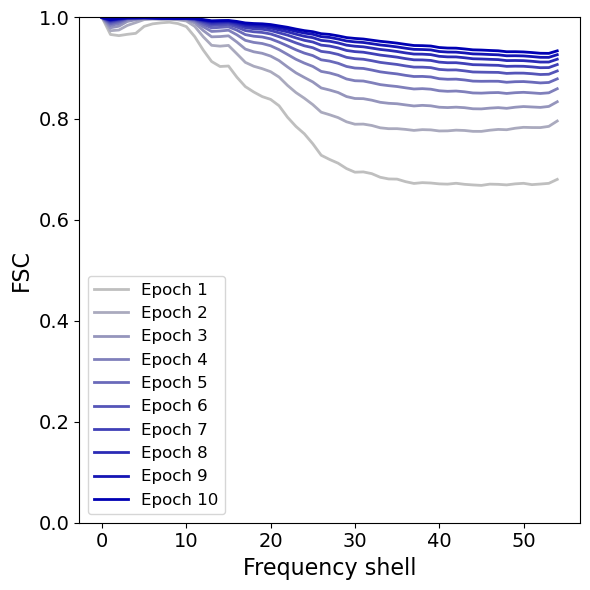

In [110]:
# plt.subplot(131)
for i in range(1, 11):
    c = (crange_other[i - 1], crange_other[i - 1], crange_color[i - 1])
    plt.plot(fsc_np[i, :], color=c, linewidth=2)
plt.ylim([0, 1])
plt.legend(lgd, fontsize=12)
# plt.title('SGD', fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig("fsc_shell_gradient_color_sgd.eps")

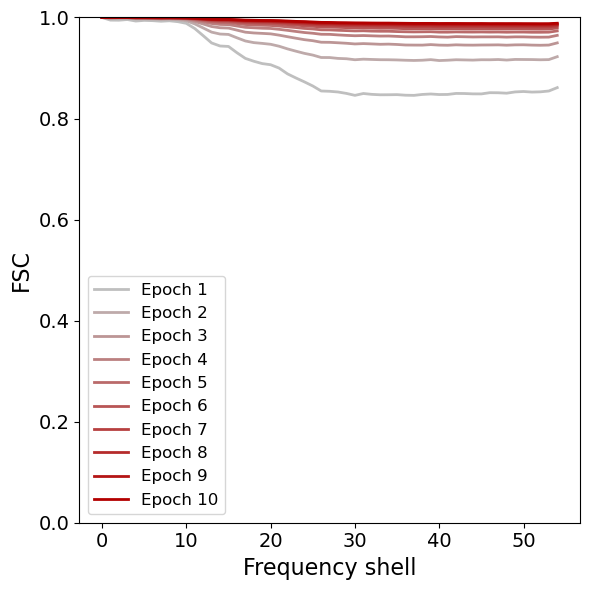

In [111]:
for i in range(1, 11):
    c = (crange_color[i - 1], crange_other[i - 1], crange_other[i - 1])
    plt.plot(fsc_pp[i, :], color=c, linewidth=2)
plt.ylim([0, 1])
plt.legend(lgd, fontsize=12)
# plt.title('SGD + precon (computed)', fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig("fsc_shell_gradient_color_sgd_p.eps")

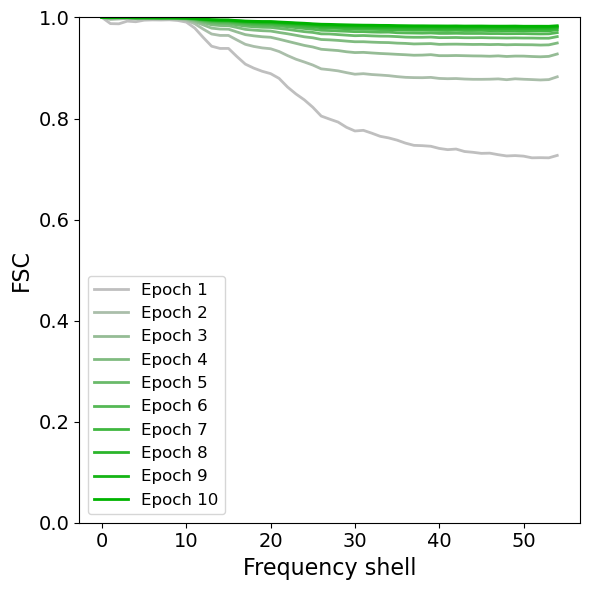

In [117]:
for i in range(1, 11):
    c = (crange_other[i - 1], crange_color[i - 1], crange_other[i - 1])
    plt.plot(fsc_ep[i, :], color=c, linewidth=2)
plt.ylim([0, 1])
plt.legend(lgd, fontsize=12)
# plt.title('SGD + precon (Hutch)', fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("FSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig("fsc_shell_gradient_color_sgd_o.eps")

## Number of epochs to a certain FSC threshold

In [123]:
thresh = 0.8

In [124]:
iters_thresh_np = jnp.argmax(fsc_np > thresh, axis=0).astype(jnp.float32)
iters_thresh_pp = jnp.argmax(fsc_pp > thresh, axis=0).astype(jnp.float32)
iters_thresh_ep = jnp.argmax(fsc_ep > thresh, axis=0).astype(jnp.float32)

# Set the zeros to nan (i.e. when the given threshold is never reached)
iters_thresh_np = iters_thresh_np.at[iters_thresh_np == 0].set(jnp.nan)
iters_thresh_pp = iters_thresh_pp.at[iters_thresh_pp == 0].set(jnp.nan)
iters_thresh_ep = iters_thresh_ep.at[iters_thresh_ep == 0].set(jnp.nan)

In [125]:
savefig = False

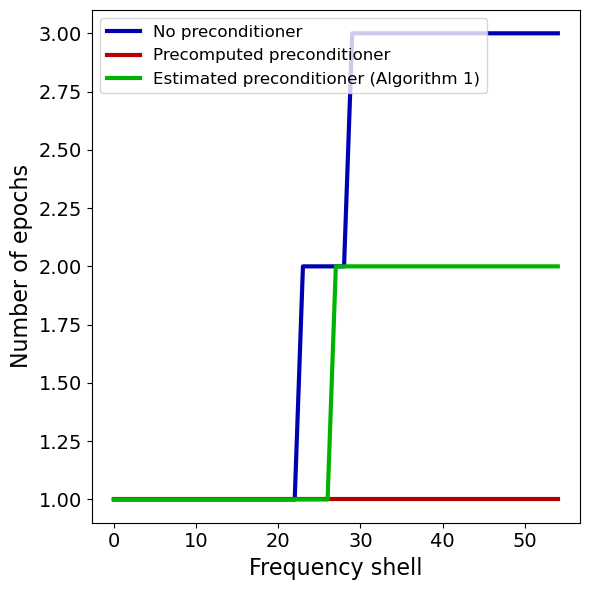

In [126]:
plt.plot(iters_thresh_np, linewidth=3, c=(0, 0, 0.7))
plt.plot(iters_thresh_pp, linewidth=3, c=(0.7, 0, 0))
plt.plot(iters_thresh_ep, linewidth=3, c=(0, 0.7, 0))

plt.legend(
    [
        "No preconditioner",
        "Precomputed preconditioner",
        "Estimated preconditioner (Algorithm 1)",
    ],
    fontsize=12,
    loc="upper left",
)
# plt.title("Fourier shell correlation (final epoch)", fontsize=22)
plt.xlabel("Frequency shell", fontsize=16)
plt.ylabel("Number of epochs", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

if savefig:
    plt.savefig(f"num_iters_fsc_thresh{thresh}.eps")
    plt.savefig(f"num_iters_fsc_thresh{thresh}_tight.eps", bbox_inches="tight")
